<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_TinyDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
from torch.utils.data import Dataset
from sklearn.datasets import make_swiss_roll

class SwissRoll(Dataset):

  def __init__(self, num_samples):
    super().__init__()
    self.data, _ = make_swiss_roll(n_samples=num_samples, noise=0.05)
    self.data = self.data[:, [0, 2]]
    self.data = torch.tensor(self.data, dtype=torch.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [241]:
import torch.nn as nn
import torch

class MLP(nn.Module):

  def __init__(self, input_dim, hidden_dim, T):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(2 * input_dim + hidden_dim, 8 * hidden_dim),
        nn.ReLU(),
        nn.Linear(8 * hidden_dim, 4 * hidden_dim),
        nn.ReLU(),
        nn.Linear(4 * hidden_dim, 2 * hidden_dim),
        nn.ReLU(),
        nn.Linear(2 * hidden_dim, input_dim)
    )
    self.time_emb = nn.Embedding(T, hidden_dim)

  def forward(self, xT, xt, t):
    t_emb = self.time_emb(t)
    t_emb = t_emb.repeat(xt.shape[0], 1)
    x = torch.cat([xT, xt, t_emb], dim=1)
    return self.layers(x)

In [242]:
import numpy as np

class DiffusionModel():
  def __init__(self, model, T, beta):
    self.model = model
    self.T = T
    self.beta = beta

  def step_forward(self, x0):
    # Sample from a Gaussian with dimensions as in x
    noise = torch.randn_like(x0)
    return (1 - self.beta) * x0 + self.beta * noise

  def forward(self, x0, t):
    # Sample from a Gaussian with dimensions as in x
    x = x0
    for i in range(t):
      x = self.step_forward(x)
    return x

  def step_reverse(self, xT, xt, t):
    return xt - self.model(xT, xt, t)

  def sample(self, num_samples, shape):
    shape = (num_samples, *shape)
    xT = torch.randn(*shape)
    t = self.T - 1
    x = xT
    while t > 0:
      x = self.step_reverse(xT, x, torch.tensor(t))
      t -= 1
    return x

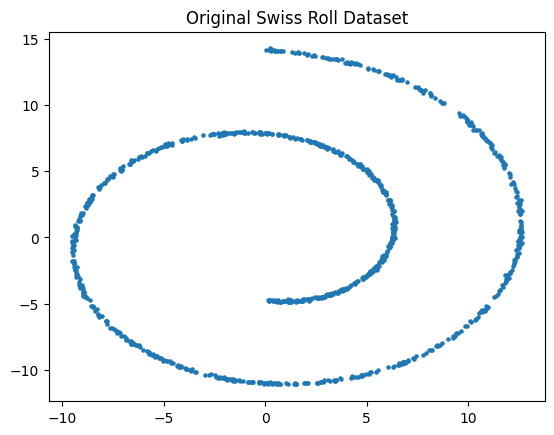

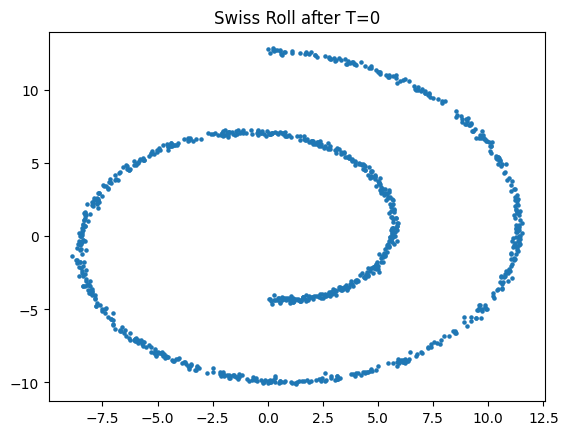

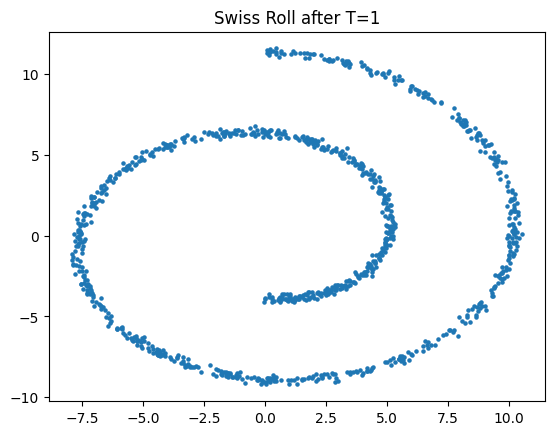

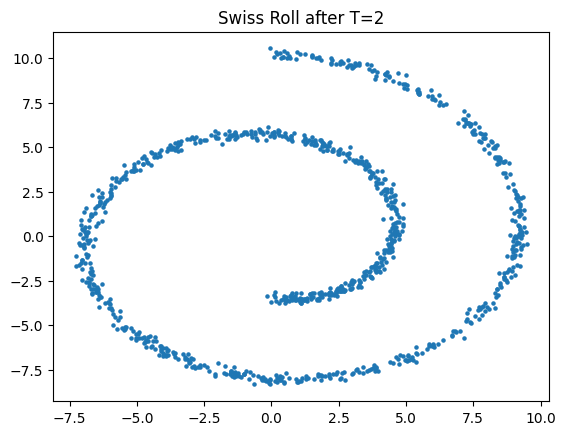

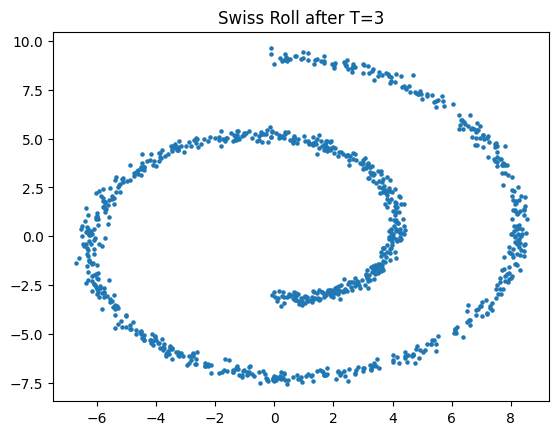

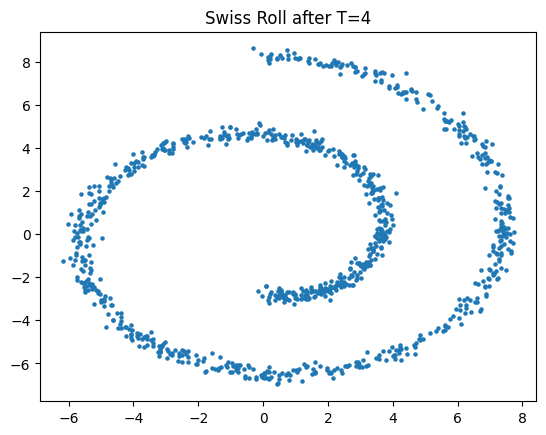

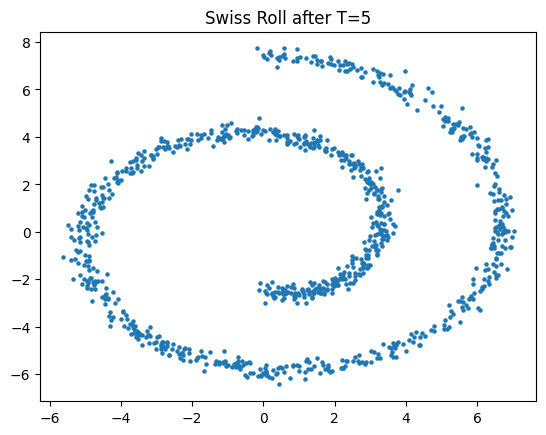

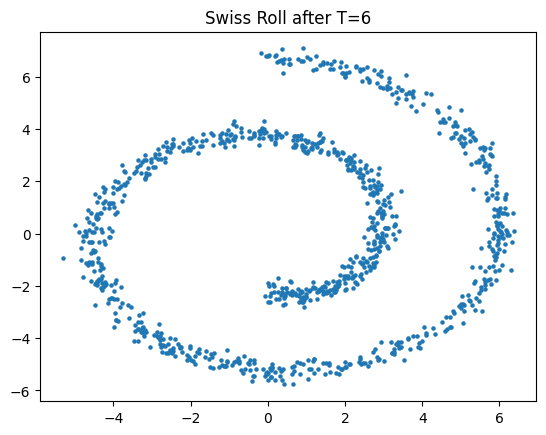

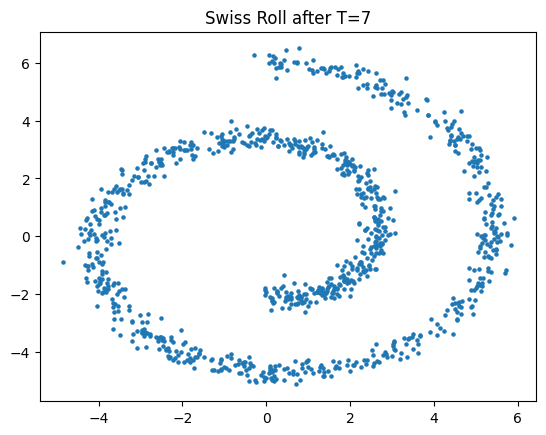

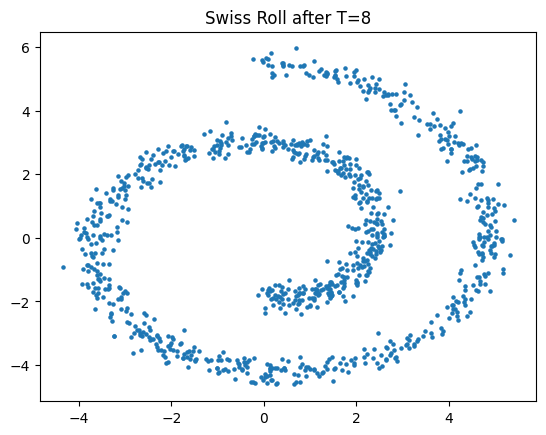

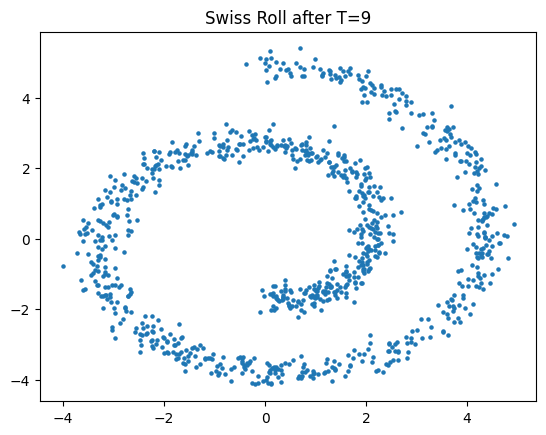

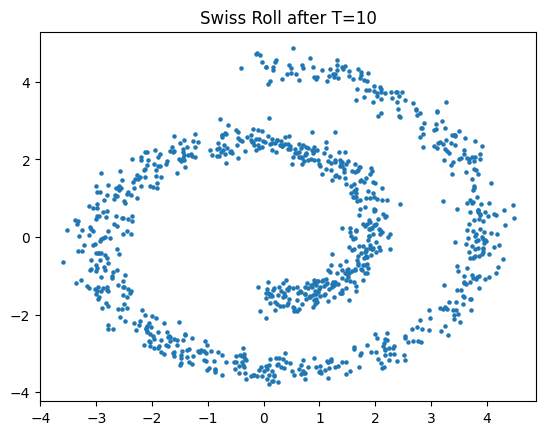

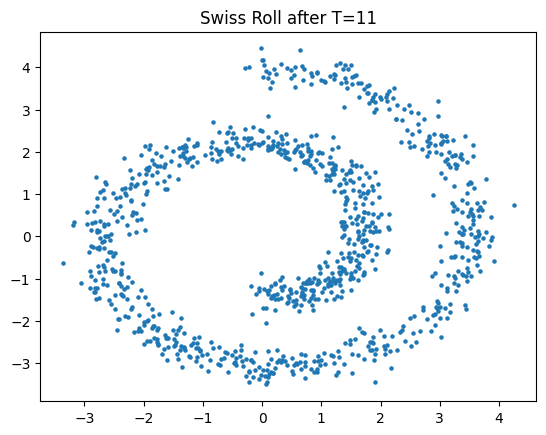

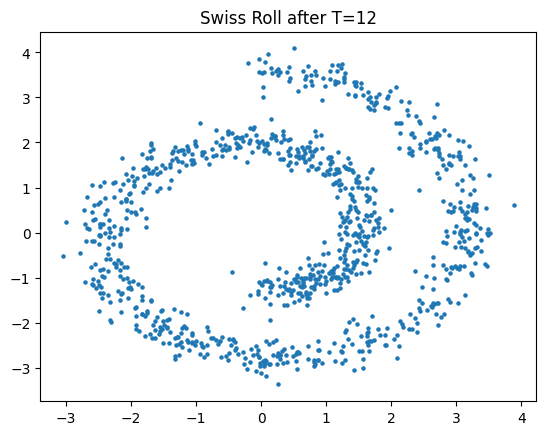

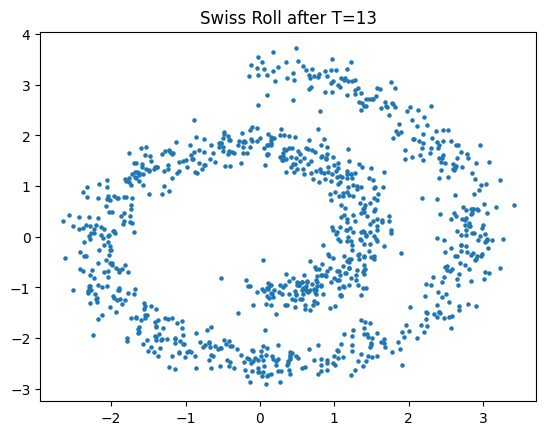

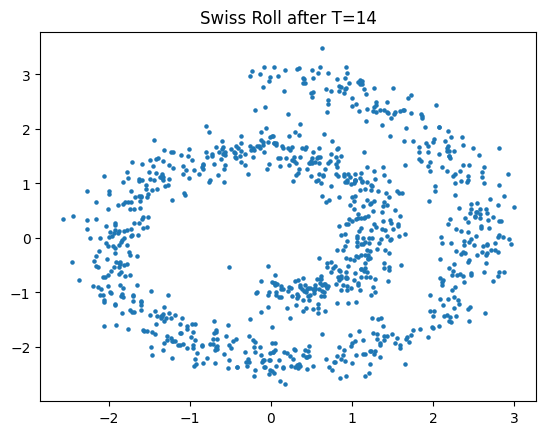

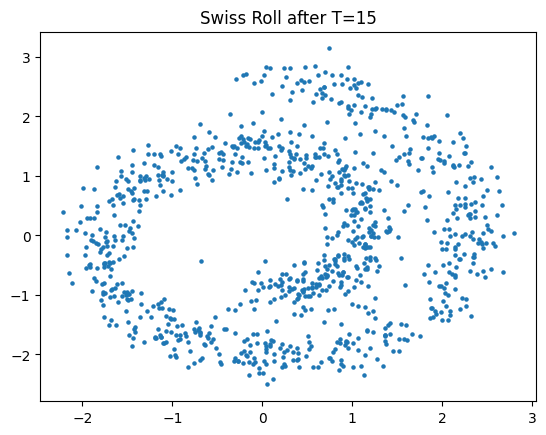

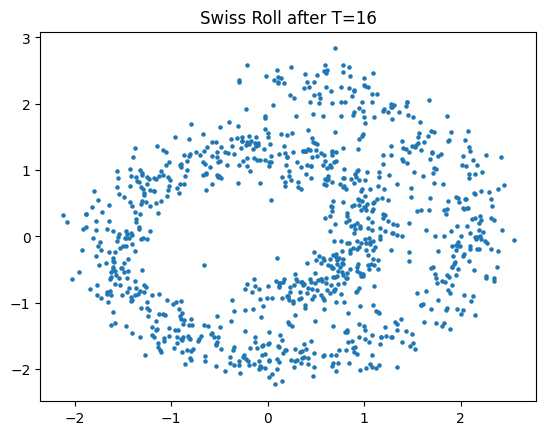

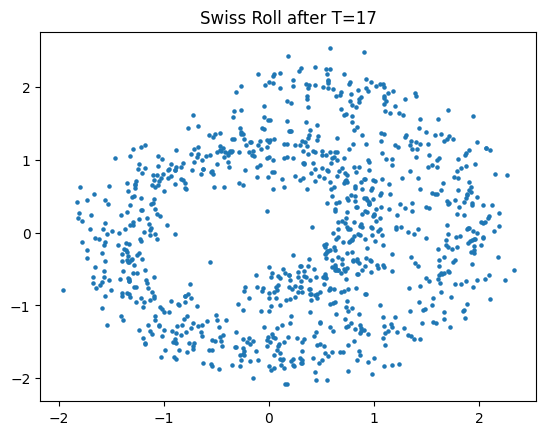

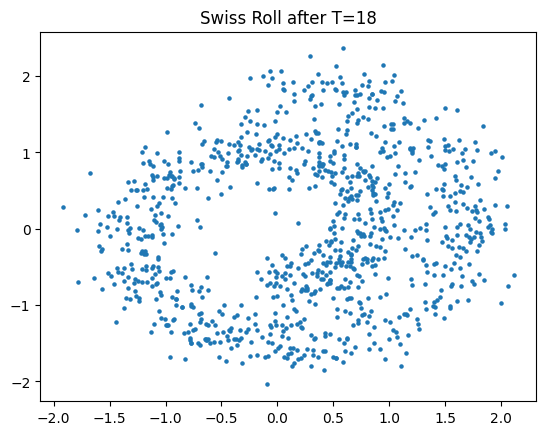

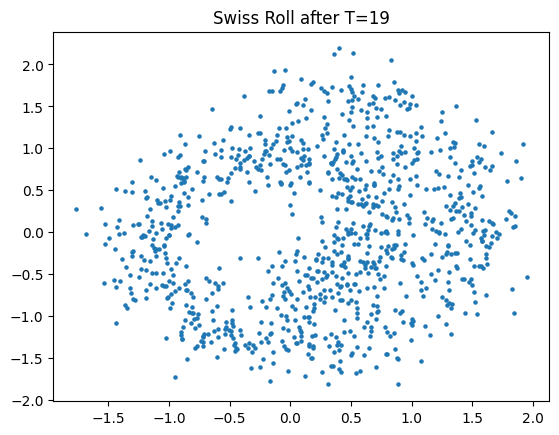

In [243]:
# prompt: Generate a dataset for the swiss roll with 1000 samples. Plot them. Then Pass them through the forward process of a diffusion model. Then plot the results after T/2 and T

import matplotlib.pyplot as plt

# Generate dataset
dataset = SwissRoll(num_samples=1000)

# Plot the original dataset
plt.figure()
plt.scatter(dataset.data[:, 0], dataset.data[:, 1], s=5)
plt.title('Original Swiss Roll Dataset')
plt.show()

# Initialize diffusion model
T = 20
model = MLP(input_dim=2, hidden_dim=64, T=T)
diffusion_model = DiffusionModel(model, T, beta=0.1)

x = dataset.data
for t in range(T):
  x = diffusion_model.step_forward(x)
  plt.figure()
  plt.scatter(x[:, 0], x[:, 1], s=5)
  plt.title(f'Swiss Roll after T={t}')
  plt.show()


In [250]:
# prompt: Train the diffusion model above using the given MLP
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15 * T
batch_size = 128

model.train()
losses = [[] for _ in range(T)]
for epoch in tqdm(range(num_epochs)):
  epoch_losses = [0 for _ in range(T)]
  for i in range(0, len(dataset), batch_size):
    x = dataset[i: i + batch_size]
    xts = [x]
    for t in range(T):
      # t = torch.randint(0, T-1, (1,), dtype=torch.long)
      xts.append(diffusion_model.step_forward(xts[-1]))

    for t in range(T-1, 0, -1):
      x_recon = xts[t] - model(xT=xts[-1], xt=xts[t], t=torch.tensor(t))
      loss = nn.functional.mse_loss(x_recon, xts[t-1])
      epoch_losses[t] += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  for t in range(T):
    losses[t].append(epoch_losses[t])


  3%|▎         | 10/300 [00:13<06:43,  1.39s/it]

Epoch [10/300], Loss: 0.0129


  7%|▋         | 20/300 [00:28<06:35,  1.41s/it]

Epoch [20/300], Loss: 0.0116


 10%|█         | 30/300 [00:42<06:22,  1.42s/it]

Epoch [30/300], Loss: 0.0122


 13%|█▎        | 40/300 [00:57<06:08,  1.42s/it]

Epoch [40/300], Loss: 0.0130


 17%|█▋        | 50/300 [01:12<05:48,  1.39s/it]

Epoch [50/300], Loss: 0.0150


 20%|██        | 60/300 [01:27<05:48,  1.45s/it]

Epoch [60/300], Loss: 0.0133


 23%|██▎       | 70/300 [01:42<05:34,  1.45s/it]

Epoch [70/300], Loss: 0.0131


 27%|██▋       | 80/300 [01:58<05:52,  1.60s/it]

Epoch [80/300], Loss: 0.0143


 30%|███       | 90/300 [02:13<05:55,  1.69s/it]

Epoch [90/300], Loss: 0.0135


 33%|███▎      | 100/300 [02:28<05:21,  1.61s/it]

Epoch [100/300], Loss: 0.0127


 37%|███▋      | 110/300 [02:43<04:54,  1.55s/it]

Epoch [110/300], Loss: 0.0111


 40%|████      | 120/300 [02:59<04:22,  1.46s/it]

Epoch [120/300], Loss: 0.0124


 43%|████▎     | 130/300 [03:14<04:03,  1.43s/it]

Epoch [130/300], Loss: 0.0129


 47%|████▋     | 140/300 [03:29<03:44,  1.40s/it]

Epoch [140/300], Loss: 0.0135


 50%|█████     | 150/300 [03:44<03:29,  1.40s/it]

Epoch [150/300], Loss: 0.0132


 53%|█████▎    | 160/300 [03:59<03:13,  1.38s/it]

Epoch [160/300], Loss: 0.0110


 57%|█████▋    | 170/300 [04:14<03:13,  1.49s/it]

Epoch [170/300], Loss: 0.0118


 60%|██████    | 180/300 [04:29<03:12,  1.61s/it]

Epoch [180/300], Loss: 0.0109


 63%|██████▎   | 190/300 [04:44<03:04,  1.68s/it]

Epoch [190/300], Loss: 0.0120


 67%|██████▋   | 200/300 [04:59<02:39,  1.59s/it]

Epoch [200/300], Loss: 0.0111


 70%|███████   | 210/300 [05:14<02:20,  1.56s/it]

Epoch [210/300], Loss: 0.0141


 73%|███████▎  | 220/300 [05:29<02:01,  1.52s/it]

Epoch [220/300], Loss: 0.0091


 77%|███████▋  | 230/300 [05:45<01:45,  1.50s/it]

Epoch [230/300], Loss: 0.0137


 80%|████████  | 240/300 [06:00<01:28,  1.47s/it]

Epoch [240/300], Loss: 0.0141


 83%|████████▎ | 250/300 [06:16<01:13,  1.47s/it]

Epoch [250/300], Loss: 0.0112


 87%|████████▋ | 260/300 [06:32<01:07,  1.68s/it]

Epoch [260/300], Loss: 0.0116


 90%|█████████ | 270/300 [06:48<00:51,  1.71s/it]

Epoch [270/300], Loss: 0.0119


 93%|█████████▎| 280/300 [07:04<00:32,  1.61s/it]

Epoch [280/300], Loss: 0.0094


 97%|█████████▋| 290/300 [07:20<00:15,  1.58s/it]

Epoch [290/300], Loss: 0.0096


100%|██████████| 300/300 [07:36<00:00,  1.52s/it]

Epoch [300/300], Loss: 0.0129


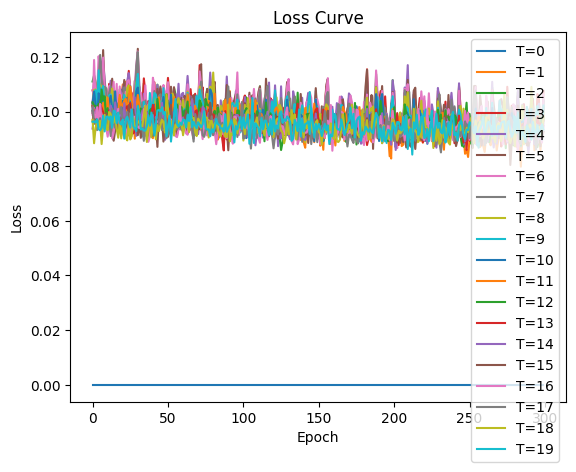

In [251]:
# Plot the loss curve
plt.figure()
for t in range(T):
  plt.plot(losses[t], label=f'T={t}')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

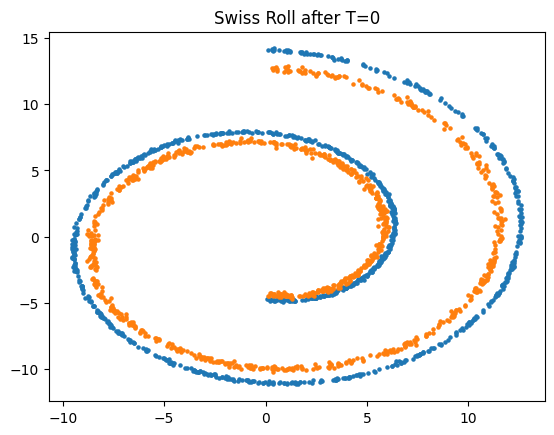

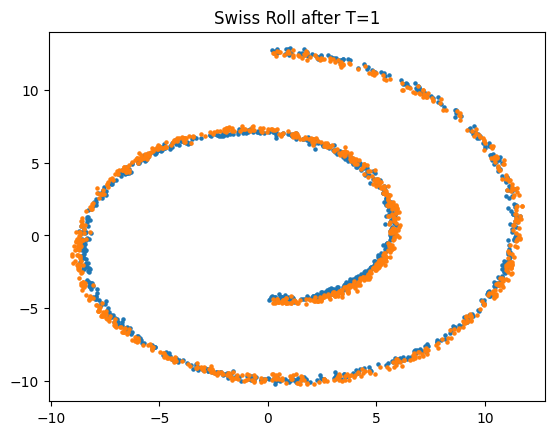

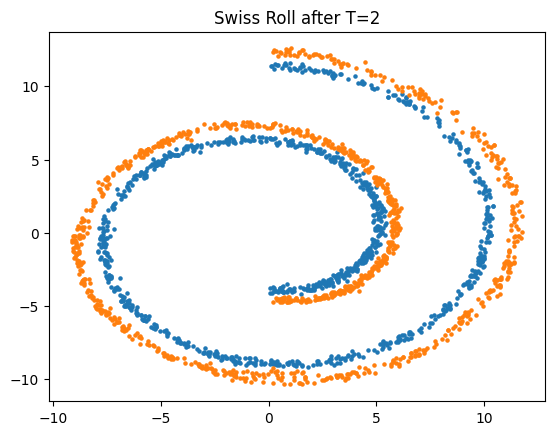

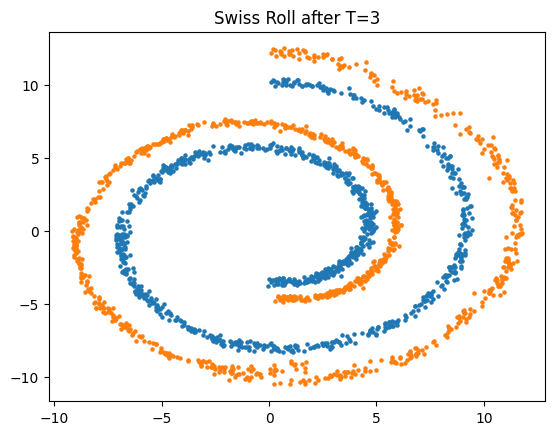

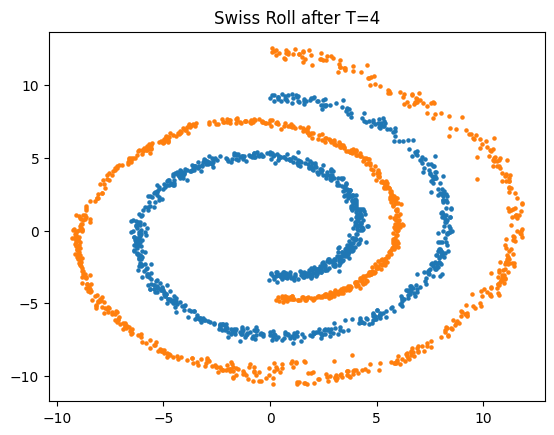

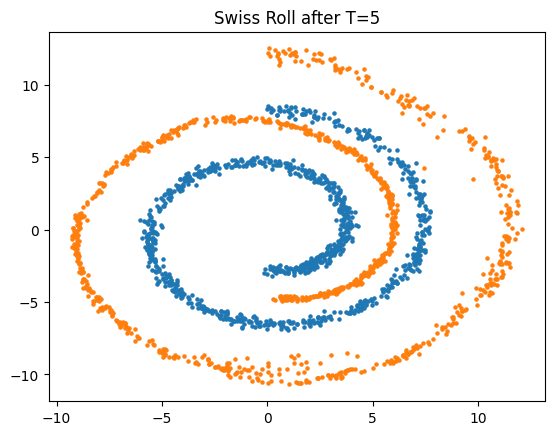

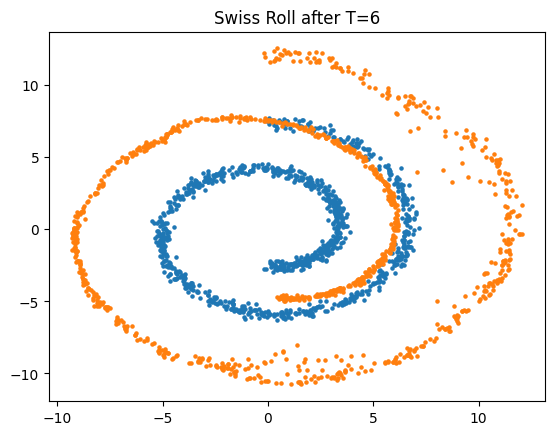

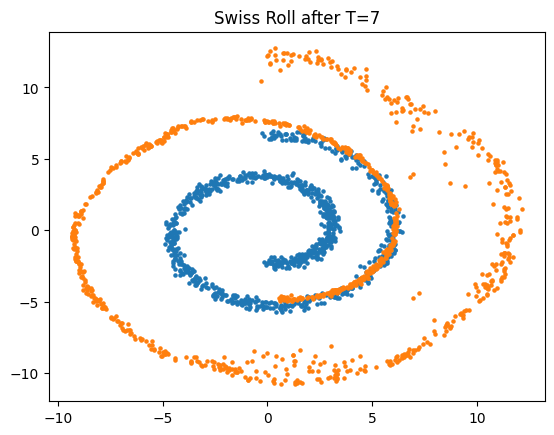

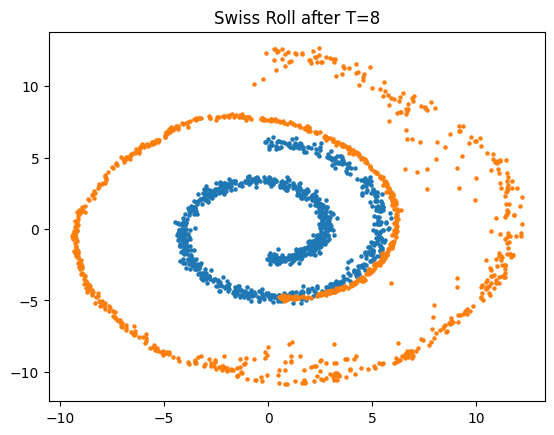

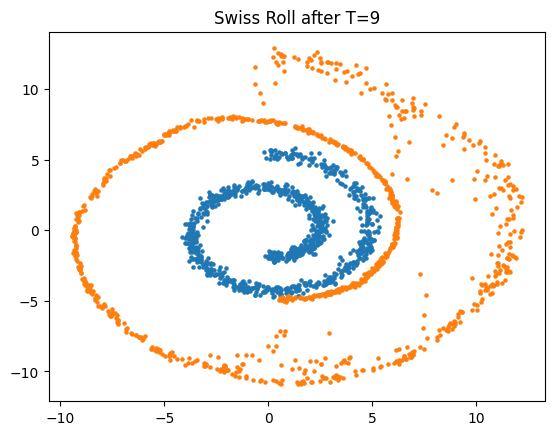

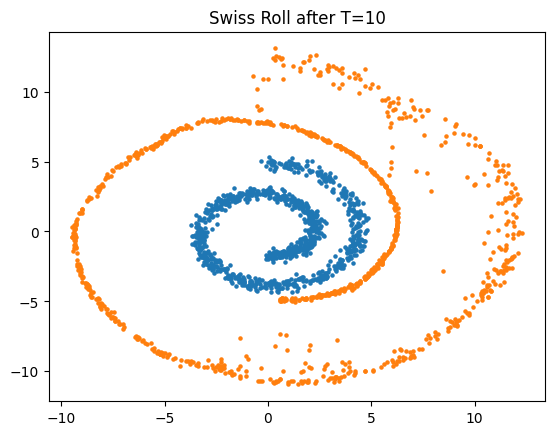

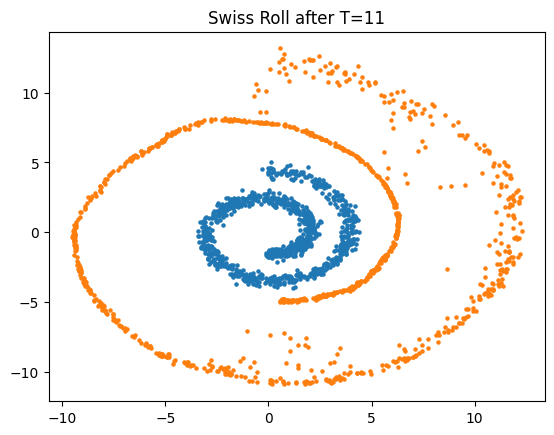

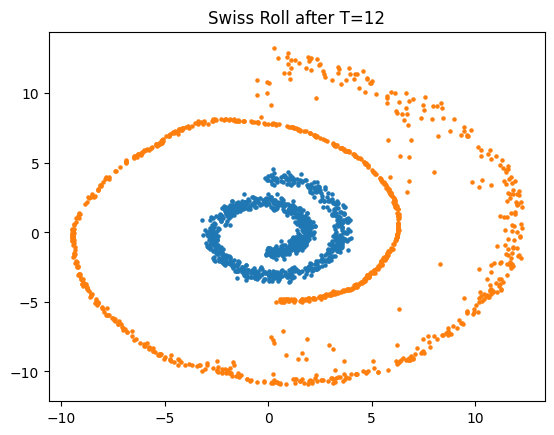

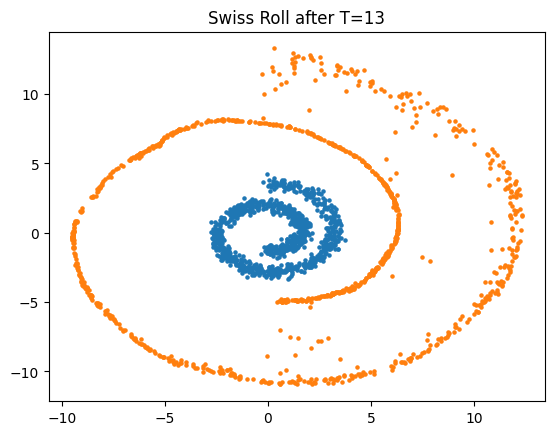

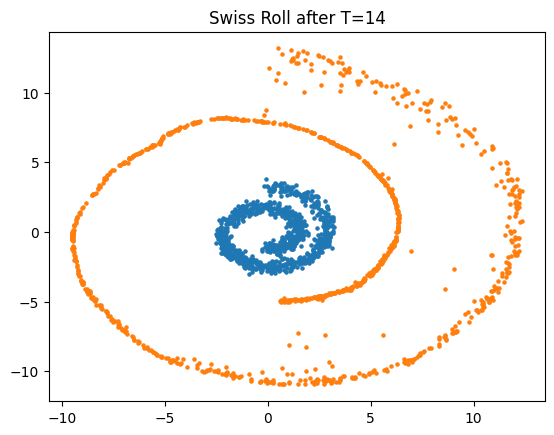

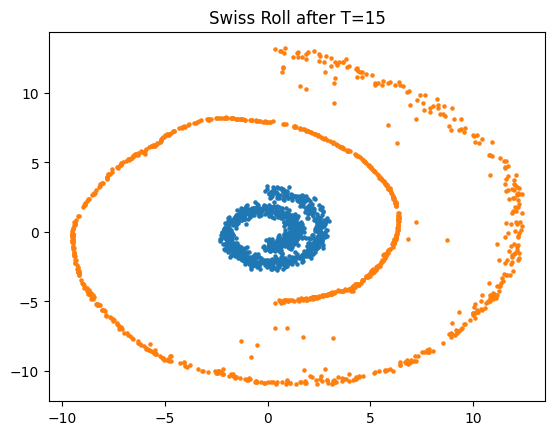

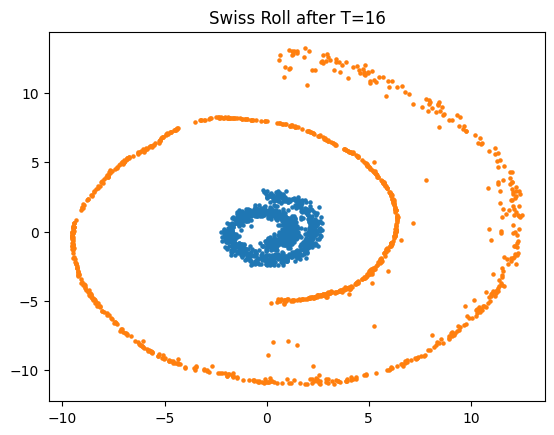

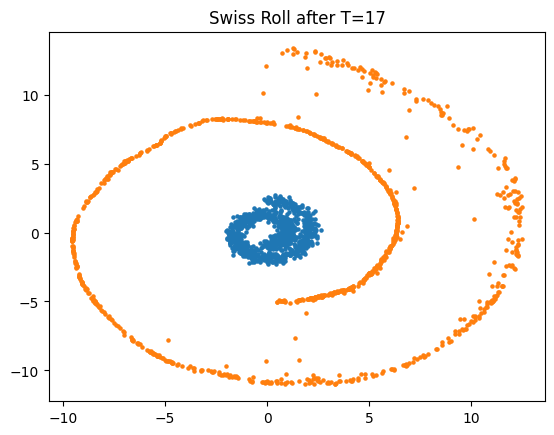

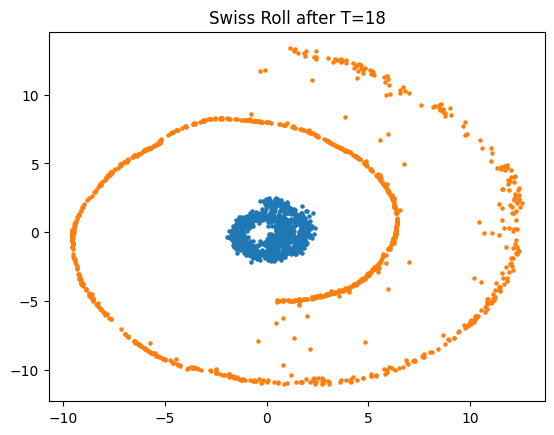

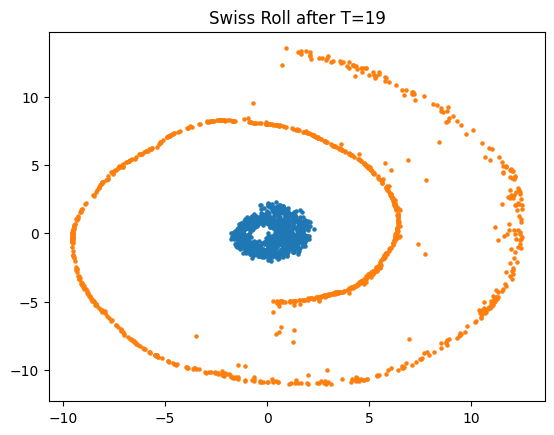

In [252]:
# prompt: Sample from the trained diffusion model

diffusion_model.model.eval()
with torch.no_grad():
  # Sample from the trained diffusion model
  num_samples = 1000
  dataset = SwissRoll(num_samples=num_samples)

  x = dataset.data
  for t in range(T):
    xt = diffusion_model.step_forward(x)
    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], s=5)

    xr = xt
    for tr in range(t, -1, -1):
      xr = diffusion_model.step_reverse(xT=xt, xt=xr, t=torch.tensor(tr))
    plt.scatter(xr[:, 0], xr[:, 1], s=5)
    plt.title(f'Swiss Roll after T={t}')
    plt.show()

    x = xt


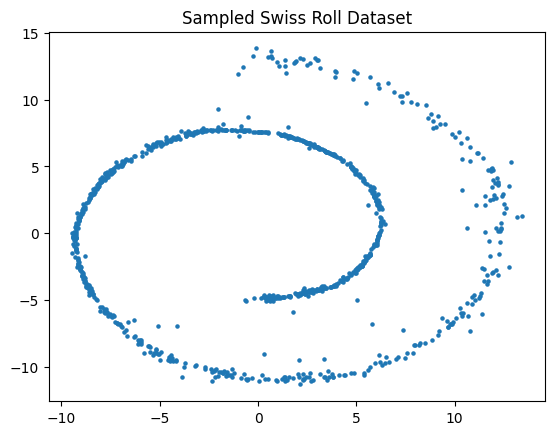

In [253]:
sample = diffusion_model.sample(num_samples=1000, shape=(2,))
plt.figure()
plt.scatter(sample[:, 0].detach().numpy(), sample[:, 1].detach().numpy(), s=5)
plt.title('Sampled Swiss Roll Dataset')
plt.show()